# Lab 5: Deconvolution

The first 4 tasks are quite simple. Task 5 will need quite some time to read and understand the material. All the detail are here. [lecture notes (Gordon Wetzstein](lecture_notes.pdf)

Credits: This lab is based on one from Gordon Wetsztein from Stanford and his materials included above.


In [2]:
#some magicto show the images inside the notebook
%pylab inline
#%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as nd

def gauss2D(shape=(3,3),sigma=0.5):
    """
    https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.**sigma) )
    #h[ h < np.finfo(h.dtype).eps*h.max() ] = 0.
    sumh = h.sum()
    if sumh != 0.:
        h /= sumh
    return h

def psf2otf(psf, dim):
    """ Based on the matlab function of the same name
        takes the psf (filter and returns a it's fft of the size specify in dim)
    """
    h, w = psf.shape
    h_dim, w_dim = dim
  
    #adds pad 0
    mat = np.lib.pad(psf, ((int((h_dim-h)/2), int((h_dim-h)/2)), (int((w_dim-w)/2), int((w_dim-w)/2))), 'constant')

    #rolls it to half
    for axis, axis_size in enumerate(mat.shape):
        mat = np.roll(mat, int(axis_size / 2), axis=axis)
    #furier transform
    otf = np.fft.fft2(mat)
    
    return otf

# A hepler function for displaying images within the notebook.
# It may display multiple images side by side, optionally apply gamma transform, and zoom the image.
def show_images(imglist, zoom=1):
    if type(imglist) is not list:
       imglist = [imglist]
    n = len(imglist)
    first_img = imglist[0]
    dpi = 77 # pyplot default?
    plt.figure(figsize=(first_img.shape[0]*zoom*n/dpi,first_img.shape[0]*zoom*n/dpi))
    for i in range(0,n):
        img = imglist[i]
        if(img.dtype == "uint16"):
            img = (img // 255.).astype(np.uint8)
        plt.subplot(1,n,i + 1)
        plt.tight_layout()    
        plt.axis('off')
        if len(img.shape) == 2:
           img = np.repeat(img[:,:,np.newaxis],3,2)
        plt.imshow(img, interpolation='nearest')    





Populating the interactive namespace from numpy and matplotlib


## Task 1: Convolution in the Frequency domain Filter (10 points)

* Implement low-pass filtering for three Gaussian convolution kernels with the following standard deviations: 0.1, 1 and 10. Use a kernel size of 35x35 pixels. You can use the given filter. In order to convolve the kernel with the image (multiply in frequency domain) both images need to be same size. For that you usethe given function psf2otf.

### Extra:
* Implement high-pass filtering for three different kernels. The choice of specific kernel parameters (radius etc.) is up to you. 

* 



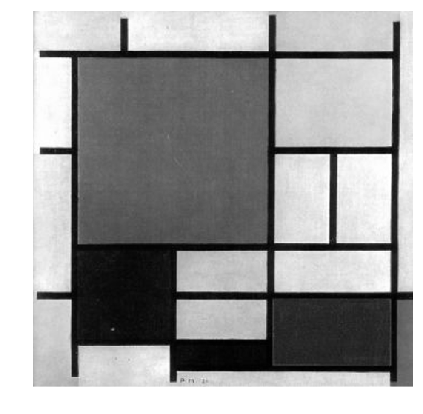

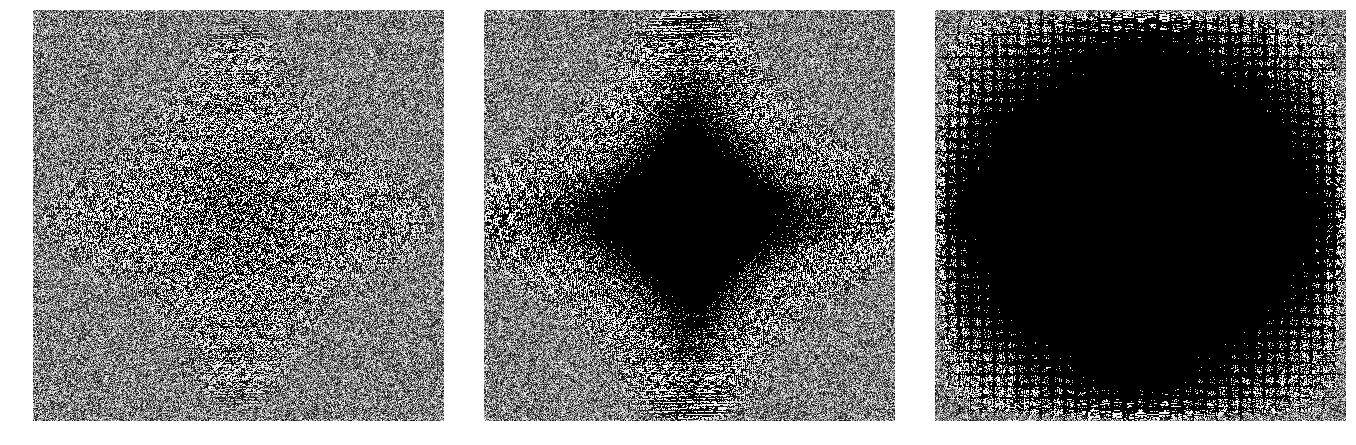

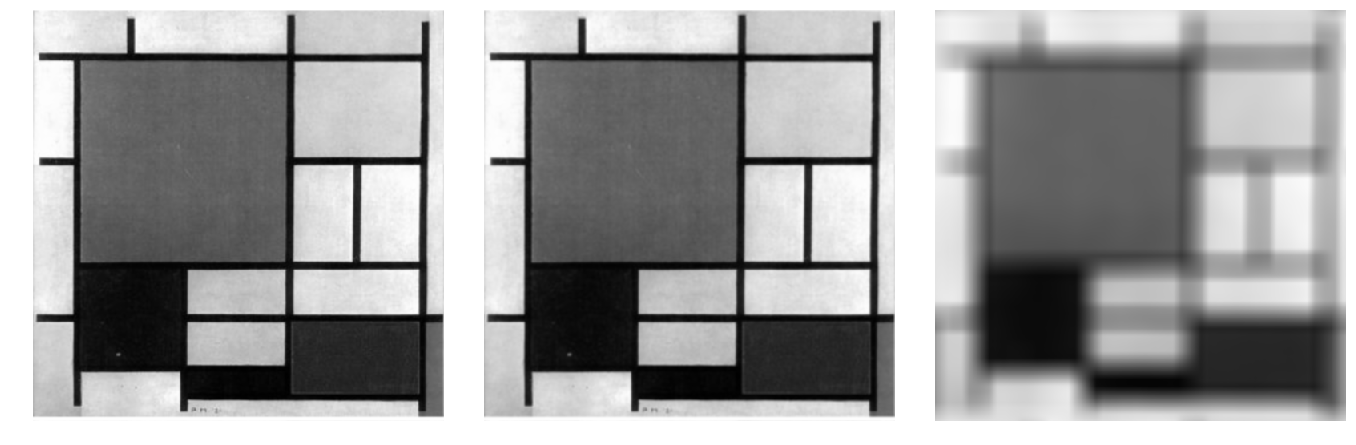

In [3]:
#they are grey images, so use only one channel

I = nd.imread('data/art_gray.png')[:,:,1]/255.

f_I = np.fft.fft2(I)
f_I1 = f_I*psf2otf(gauss2D(shape=(35,35), sigma=0.1),f_I.shape)
f_I2 = f_I*psf2otf(gauss2D(shape=(35,35), sigma=1),f_I.shape)
f_I3 = f_I*psf2otf(gauss2D(shape=(35,35), sigma=10),f_I.shape)
I21 = np.fft.ifft2(f_I1).real #inversion of fft2
I22 = np.fft.ifft2(f_I2).real #inversion of fft2
I23 = np.fft.ifft2(f_I3).real #inversion of fft2

show_images([I])
show_images([f_I1.real,f_I2.real,f_I3.real])
show_images([I21,I22,I23])

## Task 2: Band separation (10)

In previous labs we where separating bands by using a gaussian filter, and then dividing the original image by this, extracting the high frequencies. In this task you will do this in the frequency domain.

The division in of images is a sustraction in the frequency domain. Therefore, you can convolve as before and substract from the original image in the frequency domain.


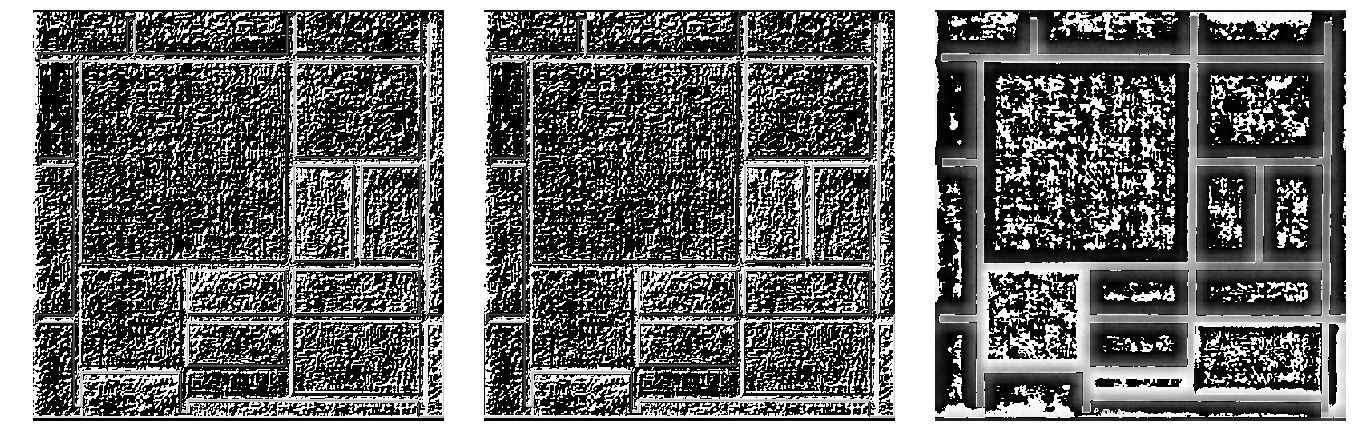

In [4]:
f_I = np.fft.fft2(I)
f_I1 = f_I - f_I*psf2otf(gauss2D(shape=(35,35), sigma=0.1),f_I.shape)
f_I2 = f_I - f_I*psf2otf(gauss2D(shape=(35,35), sigma=1),f_I.shape)
f_I3 = f_I - f_I*psf2otf(gauss2D(shape=(35,35), sigma=10),f_I.shape)
I21 = np.fft.ifft2(f_I1).real #inversion of fft2
I22 = np.fft.ifft2(f_I2).real #inversion of fft2
I23 = np.fft.ifft2(f_I3).real #inversion of fft2


show_images([I21,I22,I23])

## Task 3: Deconvolution (10 points)

Implement inverse filtering. Use the example image ‘birds_gray.png’. Blur the image with a Gaussian PSF with a standard deviation of 5. 

Show four examples with the same blur kernel but add random, additive Gaussian noise with the following standard deviations to the blurred image, before it is inversely filtered: 0, 0.001, 0.01, 0.1.

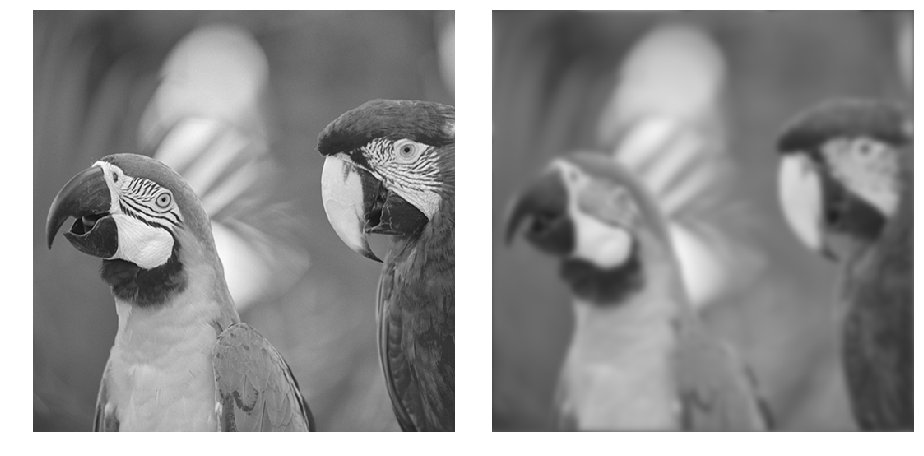

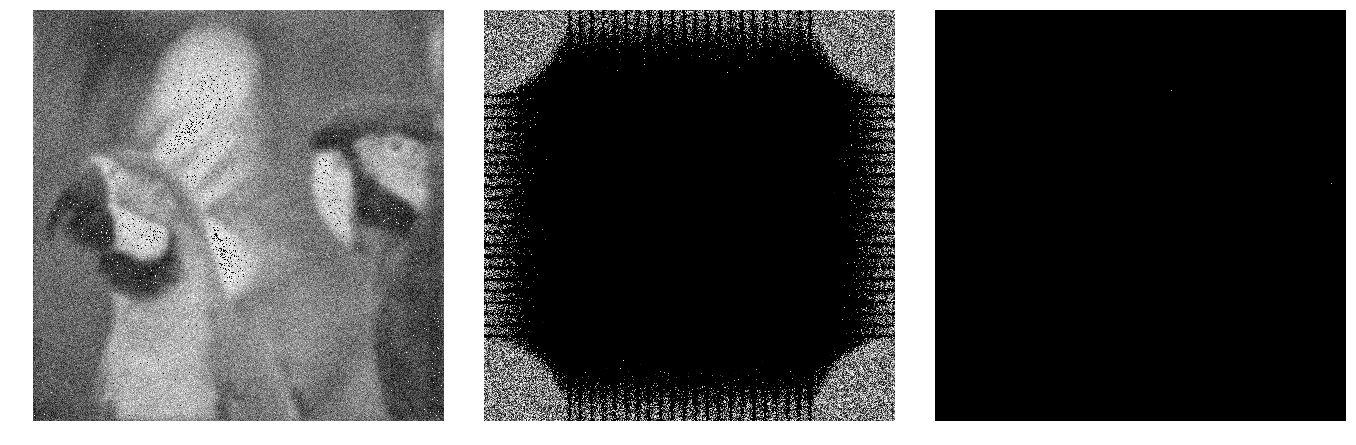

In [25]:
#I2 = I * gaussian (* means convolved here.)
I = nd.imread('data/birds_gray.png')[:,:,1]/255.

f_I = np.fft.fft2(I)
f_I = f_I*psf2otf(gauss2D(shape=(35,35), sigma=5),f_I.shape)
I2 = np.fft.ifft2(f_I).real #inversion of fft2

show_images([I,I2])
sigma1 = 0
sigma2 = 0.001
sigma3 = 0.01
sigma4 = 0.1

noise = np.random.standard_normal(I.shape)

Ib1 = I2 + noise*sigma1
Ib2 = I2 + noise*sigma2
Ib3 = I2 + noise*sigma3
Ib4 = I2 + noise*sigma4

f_I1 = np.fft.fft2(Ib1)
f_I2 = np.fft.fft2(Ib2)
f_I3 = np.fft.fft2(Ib3)
f_I4 = np.fft.fft2(Ib4)

f_I1 /= psf2otf(gauss2D(shape=(35,35), sigma=5),f_I1.shape)
f_I2 /= psf2otf(gauss2D(shape=(35,35), sigma=5),f_I2.shape)
f_I3 /= psf2otf(gauss2D(shape=(35,35), sigma=5),f_I3.shape)
f_I4 /= psf2otf(gauss2D(shape=(35,35), sigma=5),f_I4.shape)

It1= np.fft.ifft2(f_I1).real
It2= np.fft.ifft2(f_I2).real
It3= np.fft.ifft2(f_I3).real
It4= np.fft.ifft2(f_I4).real

show_images([Ib4,f_I4.real,It4])


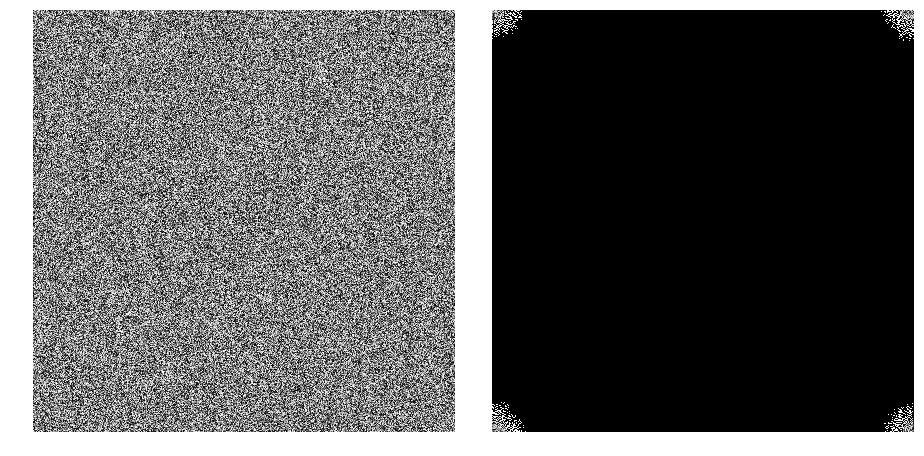

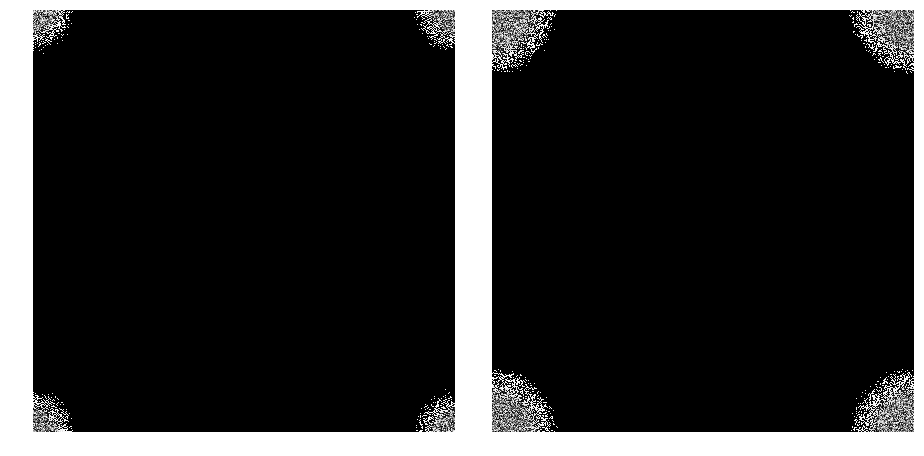

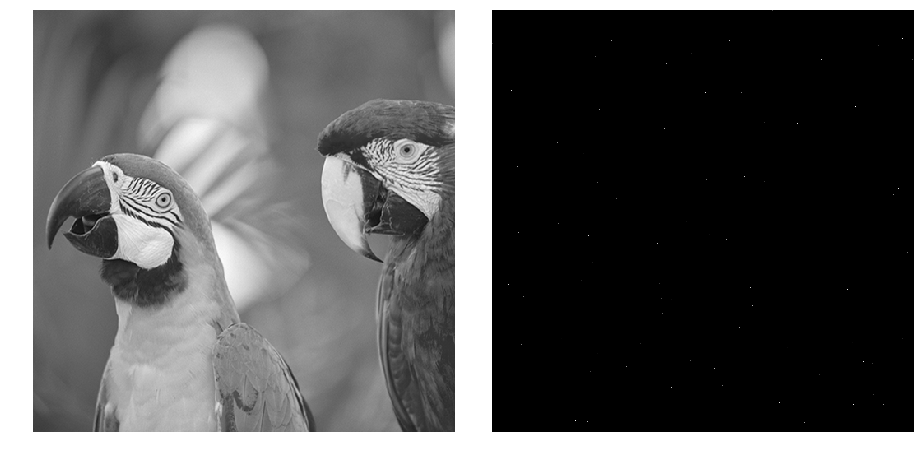

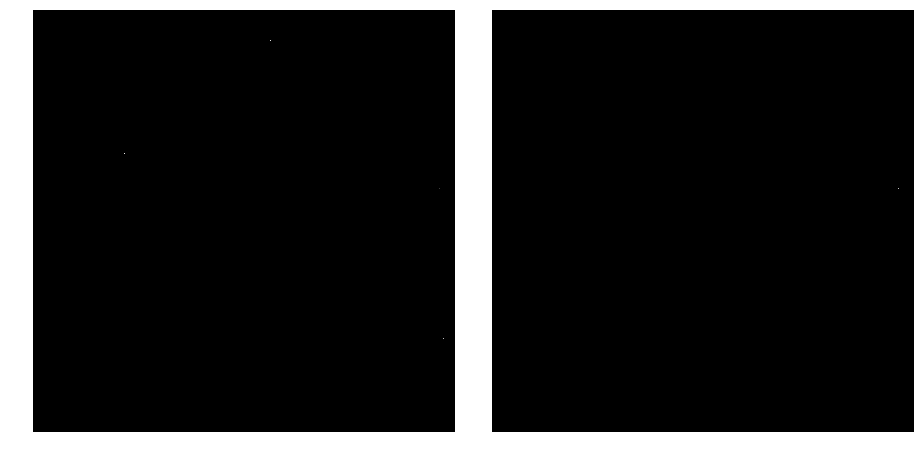

In [26]:
show_images([f_It1.real, f_It2.real])
show_images([f_It3.real, f_It4.real])
show_images([It1, It2])
show_images([It3, It4])



## Task 4: Weiner Filter (20 points)

Wiener deconvolution. This is almost the same as inverse filtering, but uses a damping factor in the
Fourier domain that depends on the noise. 

In order to compute the SNR, a common approximation to this is to choose the signal term as the mean image intensity and the noise term as the standard deviation of the (usually zero-mean Gaussian i.i.d.) noise distribution η. (look at the [lecture notes](lecture_notes.pdf) for more information).

https://en.wikipedia.org/wiki/Signal-to-noise_ratio

Plot the resulting images and report the peak signal-to-noise ratio (PSNR) for each result.

https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio

0.492246695425


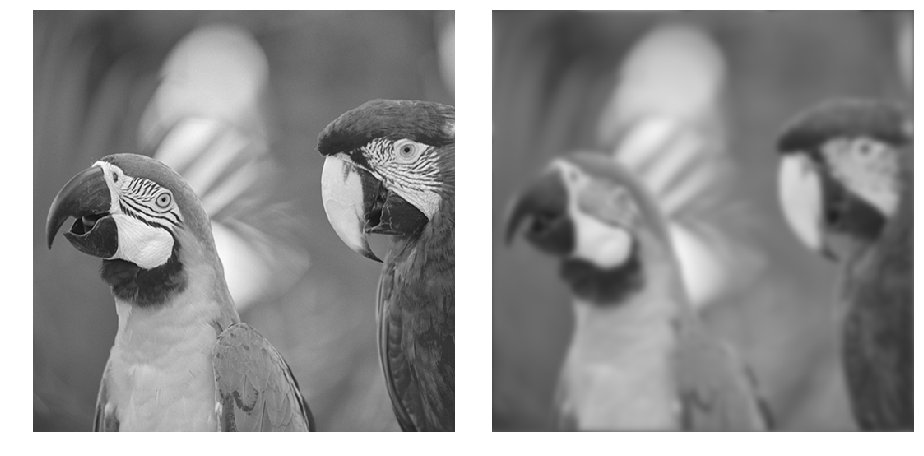

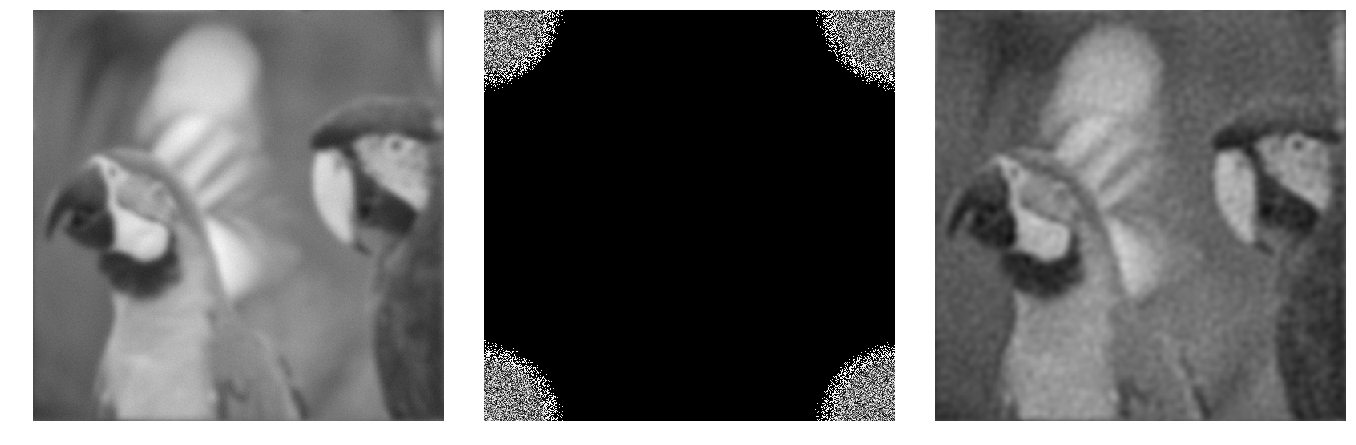

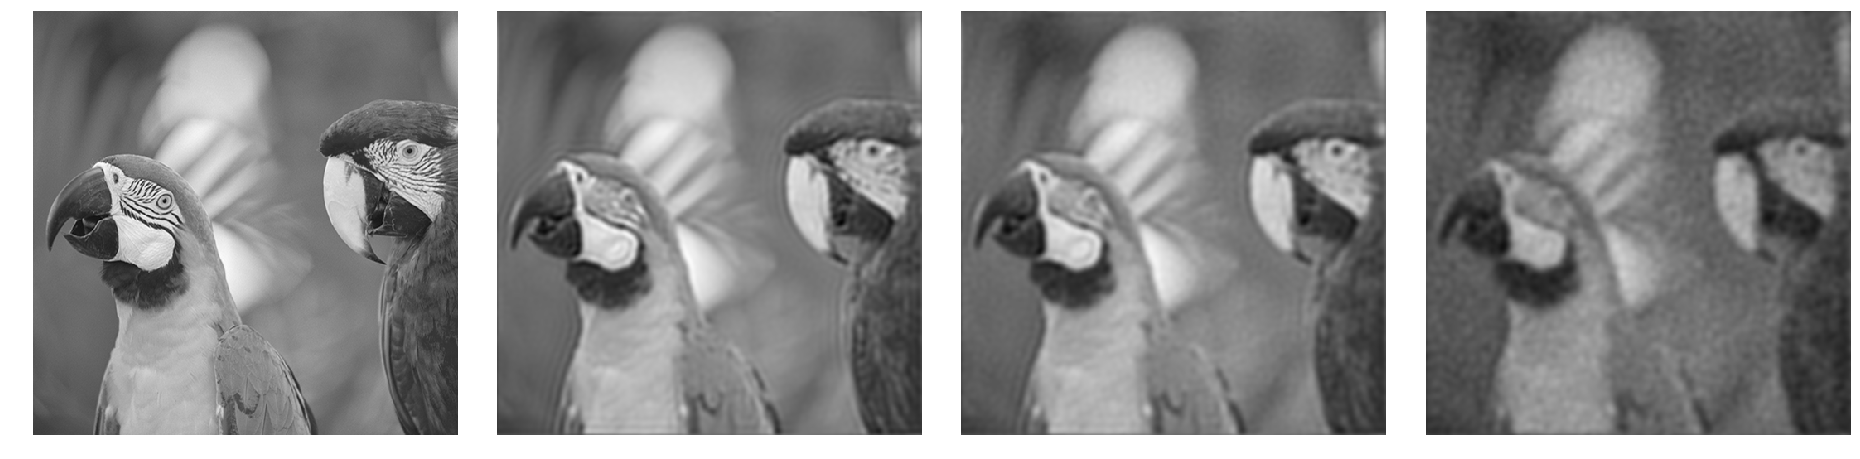

In [28]:
#I2 = I * gaussian (* means convolved here.)
I = nd.imread('data/birds_gray.png')[:,:,1]/255.

f_I = np.fft.fft2(I)
f_I = f_I*psf2otf(gauss2D(shape=(35,35), sigma=5),f_I.shape)
I2 = np.fft.ifft2(f_I).real #inversion of fft2

show_images([I,I2])
sigma1 = 0.
sigma2 = 0.001
sigma3 = 0.01
sigma4 = 0.1

noise = np.random.standard_normal(I.shape)

Ib1 = I2 + noise*sigma1
Ib2 = I2 + noise*sigma2
Ib3 = I2 + noise*sigma3
Ib4 = I2 + noise*sigma4

f_I1 = np.fft.fft2(Ib1)
f_I2 = np.fft.fft2(Ib2)
f_I3 = np.fft.fft2(Ib3)
f_I4 = np.fft.fft2(Ib4)


F_c = psf2otf(gauss2D(shape=(35,35), sigma=5),f_I0.shape)


print np.average(I)

f_It1 = f_I1 * F_c**2 / ((F_c**2 + sigma1/np.average(I)) * F_c)
f_It2 = f_I2 * F_c**2 / ((F_c**2 + sigma2/np.average(I)) * F_c)
f_It3 = f_I3 * F_c**2 / ((F_c**2 + sigma3/np.average(I)) * F_c)
f_It4 = f_I4 * F_c**2 / ((F_c**2 + sigma4/np.average(I)) * F_c)
    
    
It1= np.fft.ifft2(f_It1).real
It2= np.fft.ifft2(f_It2).real
It3= np.fft.ifft2(f_It3).real
It4= np.fft.ifft2(f_It4).real

show_images([Ib,f_It4.real,It4])
show_images([It1,It2,It3,It4])


## Task 5: ADMM Filter (50 points)

Implement deconvolution with ADMM and an anisotropic total variation (TV) prior. Use the same blur kernel as for task 2 and also the same noise settings (0.001, 0.01, 0.1). Test this for a range of parameters λ(present 3-5 values), and keep the parameter ρ = 10 fixed. Run ADMM for 100 iterations and plot the convergence (residual for each iteration) for each of your experiments. Plot the resulting images and report the PSNR for each result.

All convolution operations in ADMM should be implemented as multiplications in the Fourier domain. A convolution with the transpose kernel (i.e., multiplication with corresponding circulant matrix transpose) is implemented as a Fourier multiplication with the conjugate kernel, i.e. conj(psf2otf(psf, imageResolution)). Implement the x update as naïve inverse filtering, NOT as Wiener deconvolution. Show results for two example images: birds_gray.png and art.png. Discuss when the TV-based deconvolution works well and when it does not.

Equation 18 is the most important. The notation $F\{\}^*$ means the conjugate.

For the z update in equation 20 you are giving a function shrinkage. You don't need to implement the isotropic case.

Follow carefully the [lecture notes](lecture_notes.pdf).

You can find implementations in matlab and other problems, as well as the ADMM paper [here](http://stanford.edu/~boyd/papers/admm/).

In [133]:
import imageio as imio
I = nd.imread('data/art_gray.png')[:,:,1]/255.

c = gauss2D((5,5),0.2)

# convolution kernel for Dx and Dy
dy = np.array([[0., 0., 0.], [0., -1, 0.], [0., 1., 0.]])
dx = np.array([[0., 0., 0.], [0., -1., 1.], [0., 0., 0.]])

#precompute OTFs
cFT = psf2otf(c, I.shape)
cTFT = np.conjugate(cFT)
dxFT = psf2otf(dx, I.shape)
dxTFT = np.conjugate(dxFT)
dyFT = psf2otf(dy, I.shape)
dyTFT = np.conjugate(dyFT)

#this is for the update of z. kappa is  S(lambda_/rho)
def shrinkage(a, kappa):
    return np.maximum(0., a - kappa) - np.maximum(0., -a-kappa)


lambda_ =  .05
rho = 10

def ADMM_deconvolution(I, lambda_, rho, iterations):
    h,w = I.shape
    x = np.zeros((h,w))
    z = np.zeros((h,w,2))
    u = np.zeros((h,w,2))
    for k in range(iterations):
        pass
    
    if (mod(k,10)==0):
        img = np.clip(x, 0.,1.)
        imio.imwrite("tmp/x_"+str(k)+".jpg",img)
    return x



## Task Extra: Coded Appertures  (50 points)

Download [data](http://groups.csail.mit.edu/graphics/CodedAperture/CodedAperture-Data-LevinEtAl.zip). There should be a number of test images, and a folder with filters in mat format.

This folder contains coded aperture blur kernel calibrated at 9 different depths. Each file contains 7 different filters, computed at the same depth but in varying spatial locations (to account for redial distortion). The spatial locations of the filters correspond to 150 pixels blocks where filter #4 is the central one, (covering the range of [-75 +75] pixels from the center). The filters dont fully cover the entire frame width.

We will simplify this and take only the one in the middle. 

The idea is that using deconvolution, each filter should produce a sharp image at the areas at the right depth. 

Now, the idea is similar to a focal stack. 

### Create an “all-in-focus image” using the best result from all scales. (You should be able to reuse code from Lab 2. )

To select the best scale, you can use the following.

The structure of the algorithm is the following.
* Deblur the entire image for each of scaled kernels.
* Compute reconstruction error $e_k$ for each of the scaled images.

$e_k = y -f_k * x_k$

* For small window W around every pixel, compute the error of that pixel,

$E_k ~ \sum_{j \in W}{e_k(j)^2}$

* Select the minimum and create a depth map with the selected depths.

Simply take the values for x_k from the selected k = d(i) to create a final deblurred image. 

### Similarly, you can use it to create a depth map. (Likely, you will get noisy results here.)


[Full paper](http://groups.csail.mit.edu/graphics/CodedAperture/CodedAperture-LevinEtAl-SIGGRAPH07.pdf)

[Supplemental paper](http://groups.csail.mit.edu/graphics/CodedAperture/SparseDeconv-LevinEtAl07.pdf)

[Project page](http://groups.csail.mit.edu/graphics/CodedAperture/)



Populating the interactive namespace from numpy and matplotlib
(1, 7)
(1, 7)
(1, 7)
(1, 7)
(1, 7)
(1, 7)
(1, 7)
(1, 7)
(1, 7)


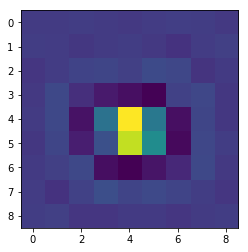

In [127]:
import scipy.io as sio
%pylab inline
#this should load the filters from all files and keep the ones in 
centerFilters = []
for i in [1,2,3,4,5,6,7,8,9]:
    fil = sio.loadmat('CodedApertureData/filts/filt_scl0%d'%i)['filts']
    print (fil.shape)
    filt = np.fliplr(fil[0][3])
    centerFilters.append(filt)
    imshow(centerFilters[-1])
    #show()

    
    